# Fastai Library Setup

In [1]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html -q
!pip install --upgrade kornia -q
!pip install allennlp==1.1.0.rc4 -q
!pip install --upgrade fastai -q

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pytorch-lightning 0.9.0 requires tensorboard==2.2.0, but you'll have tensorboard 2.3.0 which is incompatible.


In [2]:
from fastai.vision.all import *

# EDA

In [3]:
path = Path('../input/plant-pathology-2020-fgvc7')
Path.BASE_PATH = path
path.ls()

(#4) [Path('images'),Path('train.csv'),Path('test.csv'),Path('sample_submission.csv')]

In [4]:
train = pd.read_csv(path/'train.csv')
print(train.shape)
train.head()

(1821, 5)


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [5]:
sumbission = pd.read_csv(path/'sample_submission.csv')
sumbission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [6]:
test = pd.read_csv(path/'test.csv')
print(test.shape)
test.head()

(1821, 1)


,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [7]:
print('Total given Images = ', len(os.listdir(path/'images')))
print('Number of train images are {}, number of test images are {} therefore total images should be {}'.format(train.shape[0],test.shape[0], train.shape[0]+test.shape[0]))

Total given Images =  3642
Number of train images are 1821, number of test images are 1821 therefore total images should be 3642


In [8]:
(path/'images').ls()

(#3642) [Path('images/Test_956.jpg'),Path('images/Test_1412.jpg'),Path('images/Train_317.jpg'),Path('images/Test_584.jpg'),Path('images/Train_266.jpg'),Path('images/Train_1811.jpg'),Path('images/Train_1374.jpg'),Path('images/Test_1341.jpg'),Path('images/Test_420.jpg'),Path('images/Test_671.jpg')...]

In [9]:
train["label"] = (0*train.healthy + 1*train.multiple_diseases+2*train.rust + 3*train.scab)

train.drop(columns=["healthy","multiple_diseases","rust","scab"],inplace=True)

In [10]:
train.head()

,image_id,label
0,Train_0,3
1,Train_1,1
2,Train_2,0
3,Train_3,2
4,Train_4,0


# DataLoaders

In [11]:
get_x = lambda x: path/'images'/f'{x[0]}.jpg'
get_y = lambda x: x[1]

In [12]:
print(get_x(train.values[2]))
print(get_y(train.values[2]))

../input/plant-pathology-2020-fgvc7/images/Train_2.jpg
0


In [13]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x =get_x, get_y = get_y,
    splitter=RandomSplitter(),
    item_tfms=Resize(228))

In [14]:
dls = dblock.dataloaders(train)

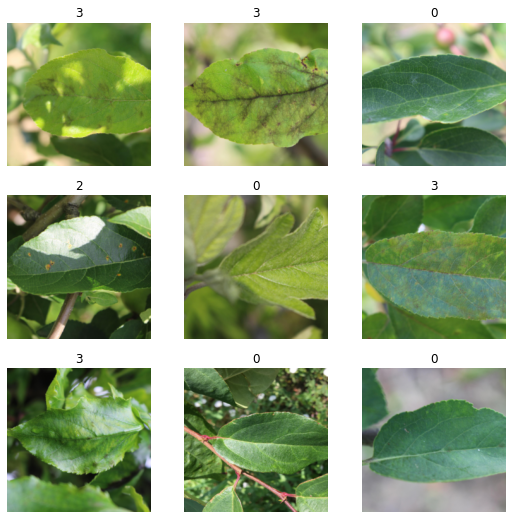

In [15]:
dls.show_batch()

In [16]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 228, 228]), torch.Size([64]))

# Training A Model

In [18]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [19]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.442659,0.640641,0.804945,01:14


epoch,train_loss,valid_loss,accuracy,time
0,0.546981,0.511389,0.865385,01:12
1,0.351750,0.527185,0.879121,01:15
2,0.235648,0.449607,0.890110,01:13
3,0.165852,0.424856,0.906593,01:13
4,0.119940,0.410807,0.898352,01:13


# Prediction of test images

In [47]:
test_images = get_image_files(path/'images')
test_images = L(x for x in test_images if x.name.startswith('Test'))

In [48]:
img1 = test_images[0]
print(img1)
learn.predict(img1)

../input/plant-pathology-2020-fgvc7/images/Test_956.jpg


('3', tensor(3), tensor([4.9952e-08, 6.7570e-06, 4.2298e-12, 9.9999e-01]))

In [34]:
test_dl = learn.dls.test_dl(test_images)

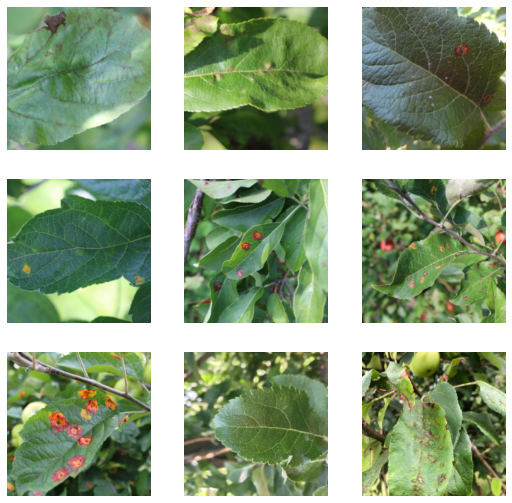

In [36]:
test_dl.show_batch()

In [37]:
preds = learn.get_preds(dl=test_dl)

In [55]:
sumbission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [56]:
# resultdf = pd.DataFrame(preds[0])
# resultdf.columns = sumbission.columns
# resultdf.head()